In [8]:
# Code from here: https://github.com/poldrack/fmri-analysis-vm/blob/master/analysis/firstlevel/FirstLevelModeling.ipynb
# And here: https://nipype.readthedocs.io/en/latest/api/generated/nipype.algorithms.modelgen.html
# These data are cleaned and smoothed in advance.
# https://neurostars.org/t/confounds-from-fmriprep-which-one-would-you-use-for-glm/326/19

import nipype.algorithms.modelgen as model   # model generation
from  nipype.interfaces import fsl
import os,sys
import numpy
import nibabel
import nilearn.plotting
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt


subject = 'sub-dspfmri12002'

bids_dir = '/blue/stevenweisberg/share/DSP_fMRI/'
clean_data_dir = os.path.join(bids_dir,'derivatives','clean_data',subject)
preproc_dir = os.path.join(bids_dir,'derivatives',subject,'func')
onsets_dir = os.path.join(bids_dir,'behavioral',
                          'Moore_2020','DSP_PsychoPy','onsets',subject)

results_dir = os.path.join(bids_dir,'derivatives','first_level',subject)

if not os.path.exists(results_dir):
    os.mkdir(results_dir)

from nipype.caching import Memory
mem = Memory(base_dir='.')

print('Using data from',bids_dir)


220126-14:09:34,474 nipype.utils INFO:
	 Running nipype version 1.4.2 (latest: 1.7.0)
Using data from /blue/stevenweisberg/share/DSP_fMRI/


In [9]:
run = '1'
task = 'dspfmri'
clean_scan_name = subject+ '_task-' + task + '_run-' + run + '_space-MNI152NLin2009cAsym_desc-preproc_bold_clean_smooth.nii.gz'
preproc_scan_name = subject+ '_task-' + task + '_run-' + run + '_space-MNI152NLin2009cAsym_desc-preproc_bold'

clean_epi=os.path.join(clean_data_dir,clean_scan_name)
preproc_epi = os.path.join(preproc_dir,preproc_scan_name + '.nii.gz')

scaninfo=json.load(open(os.path.join(preproc_dir,preproc_scan_name + '.json')))
tr=scaninfo['RepetitionTime']
print(f'TR recorded as: {tr}')

bids_event_file_name = os.path.join(onsets_dir,subject+ '_task-' + task + '_run-' + run + '_events.tsv')
bids_event_file = pd.read_csv(bids_event_file_name,sep='\t')

# We need to sub-select the columns, then convert it to a 'bunch' type object
onsets_file = bids_event_file[["onset", "duration", "trial_type"]]
onsets_file.to_dict()
onsets = Bunch(onsets_file)

TR recorded as: 1.5


In [10]:

s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = [clean_epi]
s.inputs.time_repetition = tr
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.bids_event_file = bids_event_file_name
specify_model_results = s.run()
s.inputs


bids_amplitude_column = <undefined>
bids_condition_column = trial_type
bids_event_file = ['/blue/stevenweisberg/share/DSP_fMRI/behavioral/Moore_2020/DSP_PsychoPy/onsets/sub-dspfmri12002/sub-dspfmri12002_task-dspfmri_run-1_events.tsv']
event_files = <undefined>
functional_runs = ['/blue/stevenweisberg/share/DSP_fMRI/derivatives/clean_data/sub-dspfmri12002/sub-dspfmri12002_task-dspfmri_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_clean_smooth.nii.gz']
high_pass_filter_cutoff = 128.0
input_units = secs
outlier_files = <undefined>
parameter_source = SPM
realignment_parameters = <undefined>
subject_info = <undefined>
time_repetition = 1.5

In [11]:
contrasts=[['Vid>baseline','T', 
            ['learning_vid','control_vid'],[0.5,0.5]],
           ['Learning>Control','T', 
            ['learning_vid','control_vid'],[0.5,-0.5]],
          ['instructions>Baseline','T',
           ['instructions'],[1]]]
           
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = tr,
                                    bases = {'dgamma':{'derivs': True}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=True,
                                    contrasts=contrasts)

level1design_results.outputs

220126-14:09:55,411 nipype.workflow INFO:
	 [Node] Setting-up "578d530809c842a3867598d1b1fb2ca4" in "/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-Level1Design/578d530809c842a3867598d1b1fb2ca4".
220126-14:09:55,422 nipype.workflow INFO:
	 [Node] Cached "578d530809c842a3867598d1b1fb2ca4" - collecting precomputed outputs
220126-14:09:55,422 nipype.workflow INFO:
	 [Node] "578d530809c842a3867598d1b1fb2ca4" found cached.



ev_files = ['/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-Level1Design/578d530809c842a3867598d1b1fb2ca4/ev_control_vid_0_1.txt', '/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-Level1Design/578d530809c842a3867598d1b1fb2ca4/ev_instructions_0_3.txt', '/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-Level1Design/578d530809c842a3867598d1b1fb2ca4/ev_learning_vid_0_5.txt', '/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-Level1Design/578d530809c842a3867598d1b1fb2ca4/ev_response_0_7.txt']
fsf_files = /blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-Level1Design/578d530809c842a3867598d1b1fb2ca4/run0.fsf

In [68]:
#from nipype import config
#config.enable_debug_mode()

modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)
#modelgen_results.outputs

220127-08:52:06,595 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
220127-08:52:06,598 nipype.workflow INFO:
	 [Node] Setting-up "d2ade9cdc46207279f90823509e3f7a8" in "/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-FEATModel/d2ade9cdc46207279f90823509e3f7a8".
220127-08:52:06,600 nipype.workflow DEBUG:
	 [Node] Hashes: [('ev_files', [('/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-Level1Design/578d530809c842a3867598d1b1fb2ca4/ev_control_vid_0_1.txt', 'f690694541e981b957f88116d86ea783'), ('/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-Level1Design/578d530809c842a3867598d1b1fb2ca4/ev_instructions_0_3.txt', '136da25af014c31d08f28212d7b1298a'), ('/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-Level1Design/578d530809c842a3867598d1b1fb2ca4/ev_learning_vid_0_5.txt', '8aef

OSError: No command "feat_model" found on host c0705a-s3.ufhpc. Please check that the corresponding package is installed.

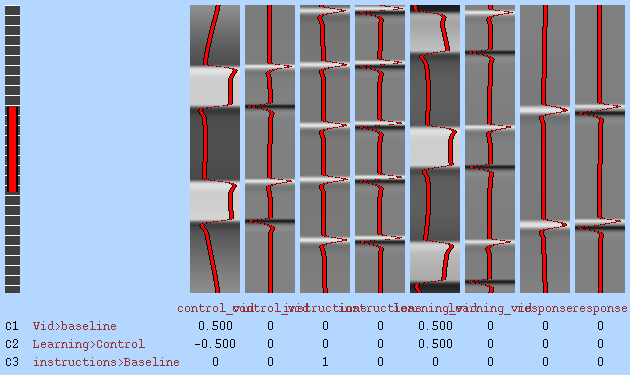

In [76]:
desmtx=numpy.loadtxt('/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-FEATModel/ad57388b31cd5d2eab891681f06a9bd2/run0.mat',skiprows=5)

from IPython.display import Image
Image(filename='/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-FEATModel/ad57388b31cd5d2eab891681f06a9bd2/run0.png') 


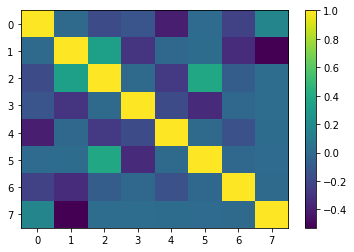

In [78]:
cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest')
plt.colorbar()


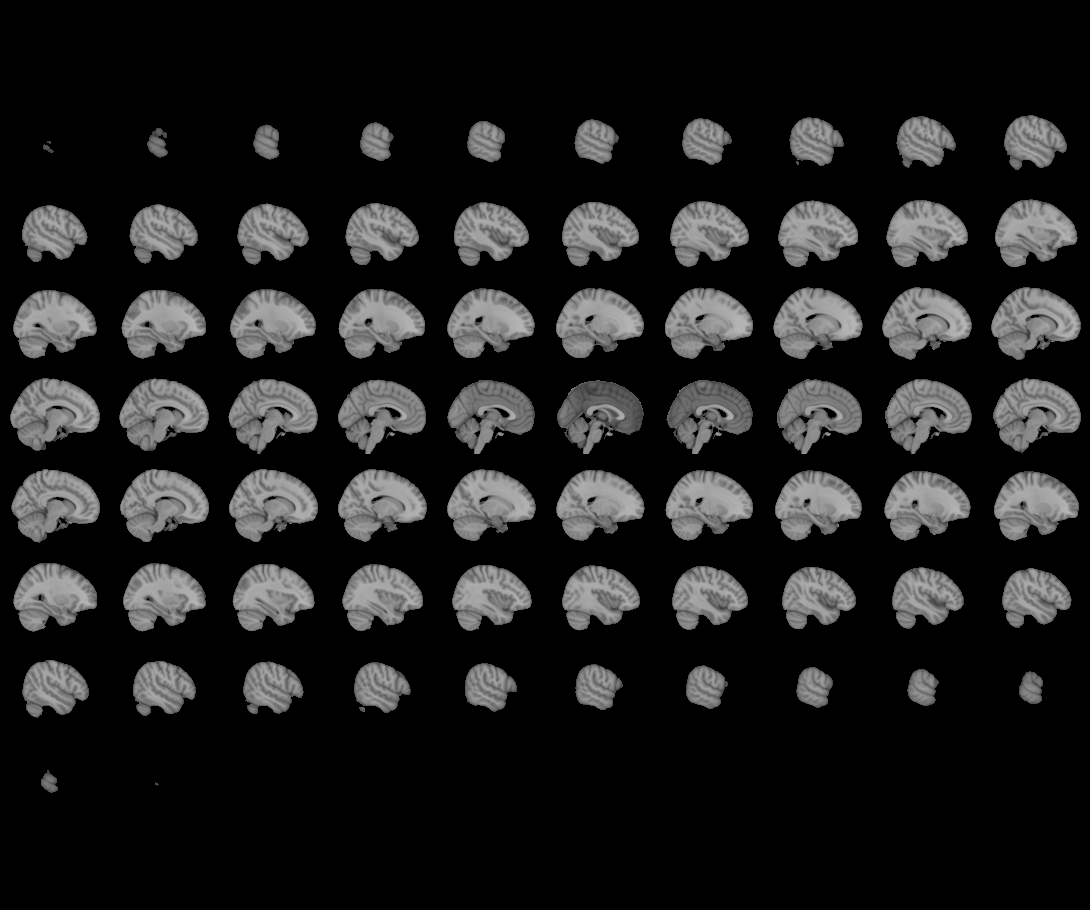
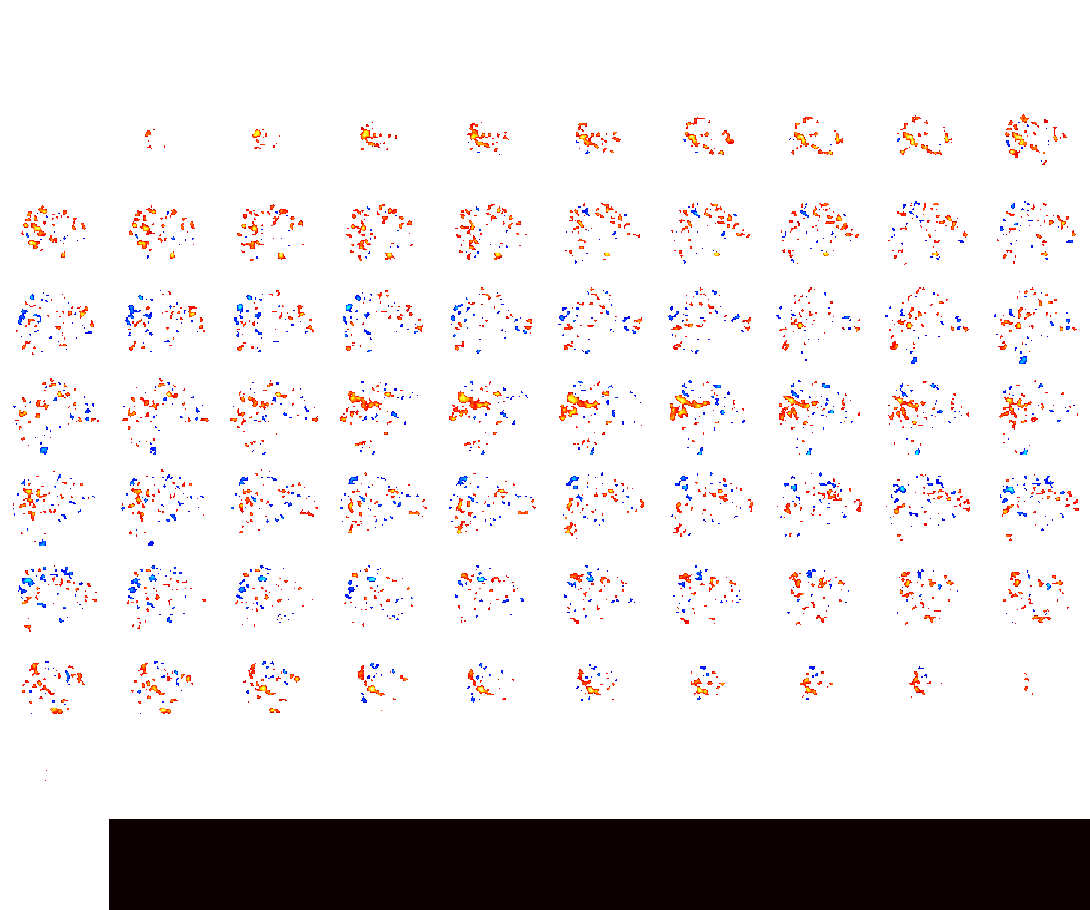

In [32]:
import nilearn.plotting
blue/stevenweisberg/share/DSP_fMRI/derivatives/clean_data/sub-dspfmri11002/sub-dspfmri11002_task-dspfmri_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_clean_smooth_mask.nii.gz
nilearn.plotting.view_img('/home/stevenweisberg/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/57bf45bda25512eef6a348e702234a87/results/cope3.nii.gz', 
                                threshold=.5)

220126-17:23:31,87 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
220126-17:23:31,90 nipype.workflow INFO:
	 [Node] Setting-up "d2ade9cdc46207279f90823509e3f7a8" in "/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-FEATModel/d2ade9cdc46207279f90823509e3f7a8".
220126-17:23:31,96 nipype.workflow DEBUG:
	 [Node] Hashes: [('ev_files', [('/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-Level1Design/578d530809c842a3867598d1b1fb2ca4/ev_control_vid_0_1.txt', 'f690694541e981b957f88116d86ea783'), ('/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-Level1Design/578d530809c842a3867598d1b1fb2ca4/ev_instructions_0_3.txt', '136da25af014c31d08f28212d7b1298a'), ('/blue/stevenweisberg/share/DSP_fMRI/code/analysis/nipype_mem/nipype-interfaces-fsl-model-Level1Design/578d530809c842a3867598d1b1fb2ca4/ev_learning_vid_0_5.txt', '8aefdc7

OSError: No command "feat_model" found on host c0705a-s3.ufhpc. Please check that the corresponding package is installed.

In [14]:
cont1 = ['Task>Baseline', 'T', ['Task-Odd', 'Task-Even'], [0.5, 0.5]]
cont2 = ['Task-Odd>Task-Even', 'T', ['Task-Odd', 'Task-Even'], [1, -1]]
cont3 = ['Task', 'F', [cont1, cont2]]
contrasts = [cont1, cont2]

firstlevel.inputs.modelfit.modelspec.input_units = 'secs'
firstlevel.inputs.modelfit.modelspec.time_repetition = TR
firstlevel.inputs.modelfit.modelspec.high_pass_filter_cutoff = hpcutoff

firstlevel.inputs.modelfit.level1design.interscan_interval = TR
firstlevel.inputs.modelfit.level1design.bases = {'dgamma': {'derivs': False}}
firstlevel.inputs.modelfit.level1design.contrasts = contrasts
firstlevel.inputs.modelfit.level1design.model_serial_correlations = True

'/blue/stevenweisberg/share/DSP_fMRI/derivatives'


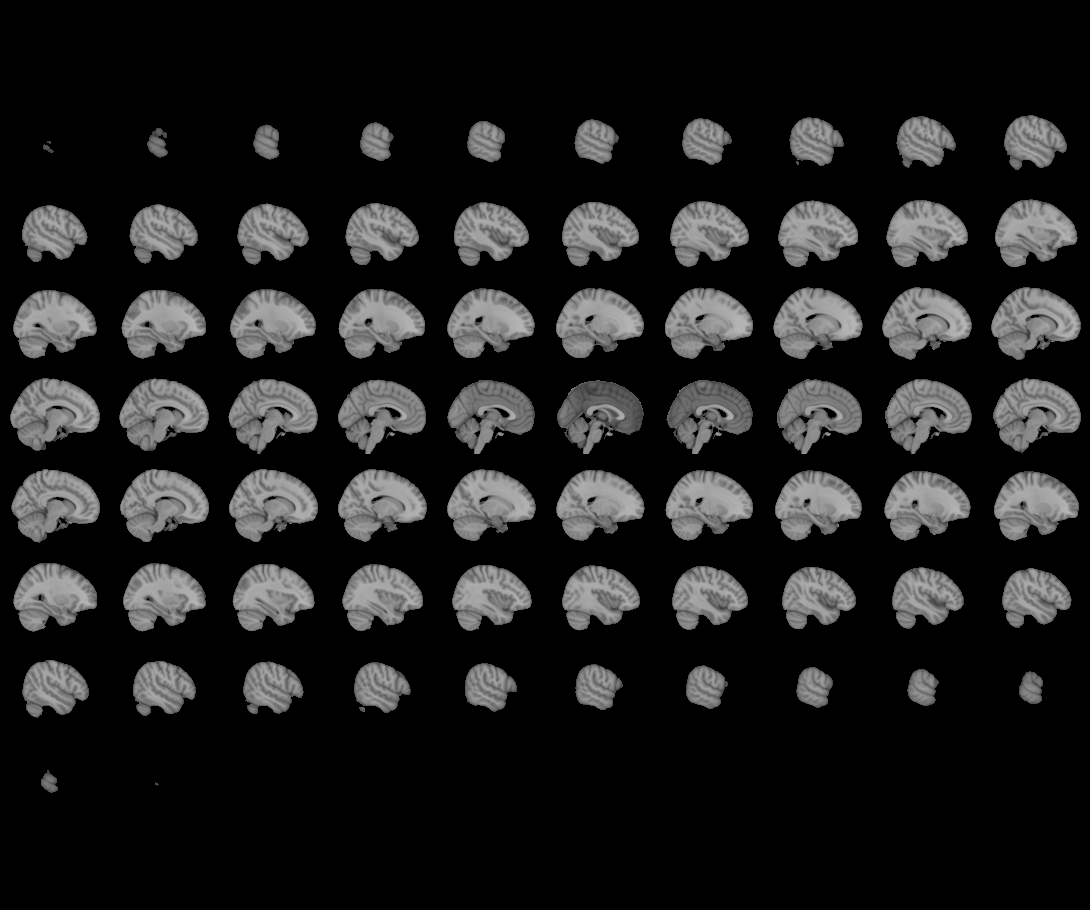
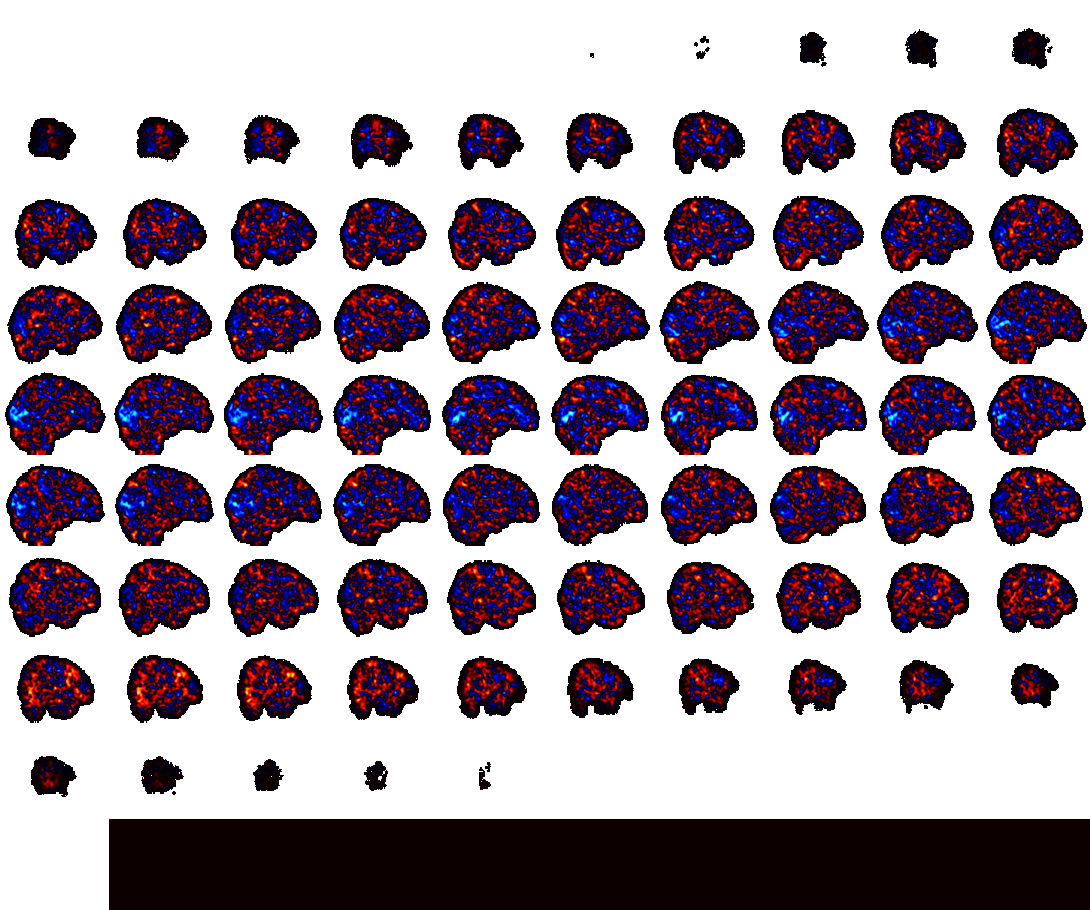

In [104]:
# Smooth!
clean_img_smooth = nilearn.image.smooth_img(clean_img, 5)

nilearn.plotting.view_img(clean_img_smooth.slicer[:,:,:,50])

In [1]:
contrasts=[['Vid>baseline','T', 
            ['learning_vid','control_vid'],[0.5,0.5]],
           ['Learning>Control','T', 
            ['learning_vid','control_vid'],[1,-1]],
           ['Control>Learning','T',['learning_vid','control_vid'],[-1,1]],
          ['instructions>Baseline','T',
           ['instructions'],[1]]]

len(contrasts)

4